In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ------------------------------------------
# NeuroStyleX - Neural Style Transfer (NST)
# Jupyter Notebook Version
# ------------------------------------------

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [4]:
# ------------------------------------------
# Step 2: Image Preprocessing Functions
# ------------------------------------------

# Function: Load and resize image
def load_img(path_to_img, max_dim=512):
    img = Image.open(path_to_img)

    # Resize image while keeping aspect ratio
    long_dim = max(img.size)
    scale = max_dim / long_dim
    new_width = int(img.size[0] * scale)
    new_height = int(img.size[1] * scale)
    
    img = img.resize((new_width, new_height))

    # Convert image to numpy array
    img = np.array(img)

    # Add batch dimension for TensorFlow (1, H, W, 3)
    img = np.expand_dims(img, axis=0)
    return img


# Function: Preprocess image for VGG19
def preprocess_img(img):
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img


# Function: Convert processed tensor back to normal image
def deprocess_img(processed_img):
    processed_img = processed_img.numpy().squeeze()

    # Reverse VGG19 preprocessing steps
    processed_img[:, :, 0] += 103.939
    processed_img[:, :, 1] += 116.779
    processed_img[:, :, 2] += 123.68

    processed_img = processed_img[:, :, ::-1]  # BGR -> RGB

    processed_img = np.clip(processed_img, 0, 255).astype('uint8')
    return processed_img


# Display image function
def show_img(img, title=None):
    img = np.squeeze(img, axis=0)
    plt.imshow(img.astype('uint8'))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


In [5]:
# ------------------------------------------
# Step 3: VGG19 Model + Feature Extraction
# ------------------------------------------

# Style layers used for extracting style patterns
STYLE_LAYERS = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Content layer used to preserve structure
CONTENT_LAYER = 'block5_conv2'


def load_vgg19():
    """
    Load VGG19 model without the fully connected (top) layers.
    Only convolution layers needed for style/content extraction.
    """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # Freeze weights
    return vgg


def get_feature_extractor():
    """
    Create a new model that outputs intermediate layer features
    needed for NST.
    """
    vgg = load_vgg19()

    outputs = [vgg.get_layer(name).output for name in STYLE_LAYERS]
    outputs += [vgg.get_layer(CONTENT_LAYER).output]

    model = tf.keras.models.Model(inputs=vgg.input, outputs=outputs)
    model.trainable = False

    return model


def extract_features(model, content_img, style_img):
    """
    Extract content & style features from VGG19.
    """
    # Preprocess before passing to VGG
    content_img = preprocess_img(content_img)
    style_img = preprocess_img(style_img)

    # Forward pass
    style_outputs = model(style_img)
    content_outputs = model(content_img)

    # First 5 outputs = style layers
    style_features = style_outputs[:len(STYLE_LAYERS)]

    # Last layer = content feature
    content_feature = content_outputs[-1]

    return style_features, content_feature


In [6]:
# ------------------------------------------
# Step 4: Loss Functions for Neural Style Transfer
# ------------------------------------------

# CONTENT LOSS
def content_loss(content_feature, generated_feature):
    """
    Measures how different the content of generated image
    is from the original content image.
    """
    return tf.reduce_mean(tf.square(content_feature - generated_feature))


# GRAM MATRIX for computing style similarity
def gram_matrix(feature_map):
    """
    Computes Gram Matrix - captures texture & style.
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', feature_map, feature_map)
    num_locations = tf.cast(tf.shape(feature_map)[1] * tf.shape(feature_map)[2], tf.float32)
    return result / num_locations


# STYLE LOSS
def style_loss(style_features, generated_features):
    """
    Measures how different the style of generated image is
    from style image's features.
    """
    total_style_loss = 0

    for style_feature, gen_feature in zip(style_features, generated_features):
        gram_s = gram_matrix(style_feature)
        gram_g = gram_matrix(gen_feature)

        layer_loss = tf.reduce_mean(tf.square(gram_s - gram_g))
        total_style_loss += layer_loss

    # Average over all style layers
    return total_style_loss / len(style_features)


# TOTAL LOSS (Style + Content)
def total_loss(style_features, content_feature, generated_features, alpha=1e4, beta=1e-2):
    """
    Combines content loss and style loss.
    alpha = style weight
    beta = content weight
    """
    # Extract generated content layer
    gen_content = generated_features[-1]

    # Generated style layers
    gen_style = generated_features[:-1]

    s_loss = style_loss(style_features, gen_style)
    c_loss = content_loss(content_feature, gen_content)

    total = alpha * s_loss + beta * c_loss
    return total, s_loss, c_loss


In [7]:
# ------------------------------------------
# Step 5: Optimization Step (Train the Generated Image)
# ------------------------------------------

# Optimizer for updating the generated image
optimizer = tf.optimizers.Adam(learning_rate=0.02)


@tf.function()
def train_step(generated_image, model, style_features, content_feature, alpha=1e4, beta=1e-2):
    """
    One training step of updating the generated image.
    Performs:
        - Forward pass
        - Loss computation
        - Backpropagation
        - Gradient update
    """
    with tf.GradientTape() as tape:
        # Preprocess generated image before passing through VGG
        gen_img_processed = preprocess_img(generated_image)
        gen_features = model(gen_img_processed)

        # Compute combined loss
        total, s_loss, c_loss = total_loss(
            style_features,
            content_feature,
            gen_features,
            alpha,
            beta
        )

    # Compute gradients of generated image
    grads = tape.gradient(total, generated_image)

    # Update generated image
    optimizer.apply_gradients([(grads, generated_image)])

    # Keep pixel values valid
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

    return total, s_loss, c_loss


In [8]:
# ------------------------------------------
# Step 6: Full Neural Style Transfer (NST) Training Loop
# ------------------------------------------

def neural_style_transfer(content_path, style_path, epochs=12, steps_per_epoch=100):
    """
    Runs the complete NST training process.
    """
    print("Loading images...")

    # Load content & style images
    content_img = load_img(content_path)
    style_img = load_img(style_path)

    show_img(content_img, "Content Image")
    show_img(style_img, "Style Image")

    print("Loading VGG19 model...")
    feature_extractor = get_feature_extractor()

    print("Extracting style & content features...")
    style_features, content_feature = extract_features(
        feature_extractor, content_img, style_img
    )

    # Initialize generated image as a copy of content image
    generated_image = tf.Variable(content_img, dtype=tf.float32)

    print("\nStarting NST Training...\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        for step in range(steps_per_epoch):
            total, s_loss, c_loss = train_step(
                generated_image,
                feature_extractor,
                style_features,
                content_feature,
                alpha=1e4,   # Style weight
                beta=1e-2    # Content weight
            )

            if step % 20 == 0:
                print(f"  Step {step}/{steps_per_epoch} | Total Loss: {total.numpy():.2f}")

        # Show intermediate result each epoch
        img = deprocess_img(generated_image)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Output After Epoch {epoch+1}")
        plt.axis("off")
        plt.show()

    print("\nTraining Completed 🎉")

    # Final output
    final_img = deprocess_img(generated_image)
    return final_img


Loading images...


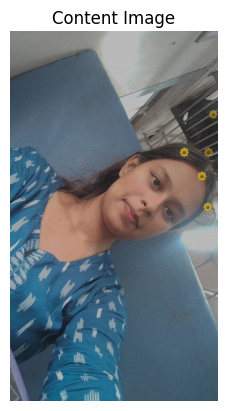

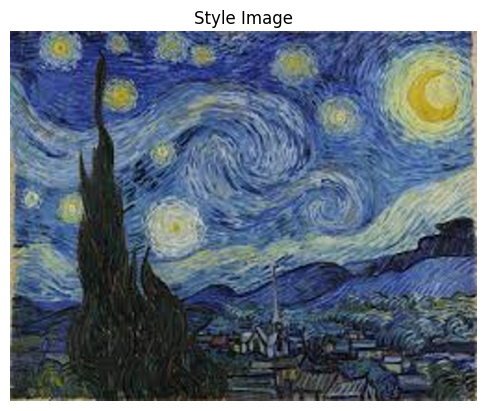

Loading VGG19 model...
Extracting style & content features...

Starting NST Training...

Epoch 1/6
  Step 0/80 | Total Loss: 83293013803008.00
  Step 20/80 | Total Loss: 74640542138368.00
  Step 40/80 | Total Loss: 67206431899648.00
  Step 60/80 | Total Loss: 60450779693056.00


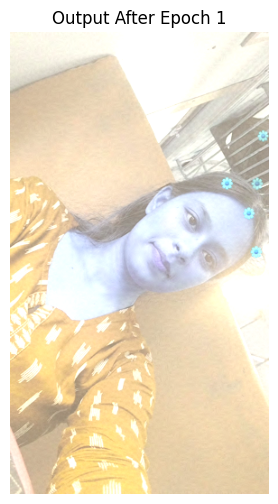

Epoch 2/6
  Step 0/80 | Total Loss: 54307634282496.00
  Step 20/80 | Total Loss: 48735757271040.00
  Step 40/80 | Total Loss: 43672183767040.00
  Step 60/80 | Total Loss: 39092007993344.00


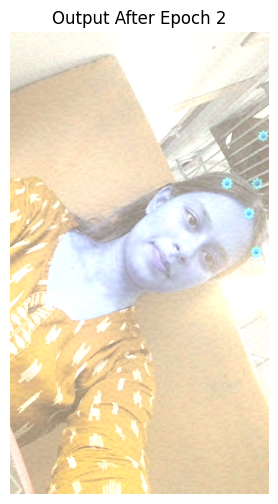

Epoch 3/6
  Step 0/80 | Total Loss: 34958745796608.00
  Step 20/80 | Total Loss: 31264973258752.00
  Step 40/80 | Total Loss: 27999497879552.00
  Step 60/80 | Total Loss: 25126479331328.00


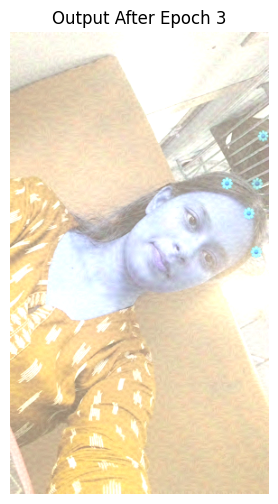

Epoch 4/6
  Step 0/80 | Total Loss: 22621334798336.00
  Step 20/80 | Total Loss: 20444090466304.00
  Step 40/80 | Total Loss: 18559558221824.00
  Step 60/80 | Total Loss: 16921174999040.00


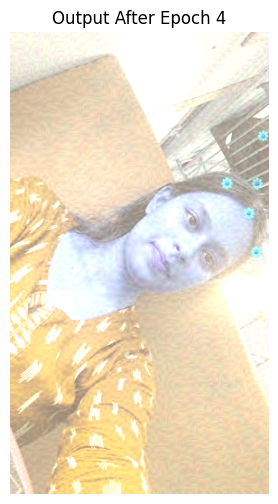

Epoch 5/6
  Step 0/80 | Total Loss: 15493087887360.00
  Step 20/80 | Total Loss: 14240528203776.00
  Step 40/80 | Total Loss: 13133175324672.00
  Step 60/80 | Total Loss: 12149226209280.00


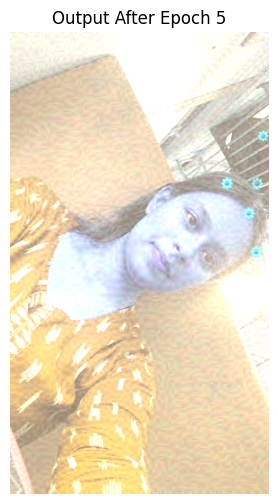

Epoch 6/6
  Step 0/80 | Total Loss: 11269530714112.00
  Step 20/80 | Total Loss: 10479346909184.00
  Step 40/80 | Total Loss: 9768758411264.00
  Step 60/80 | Total Loss: 9126589497344.00


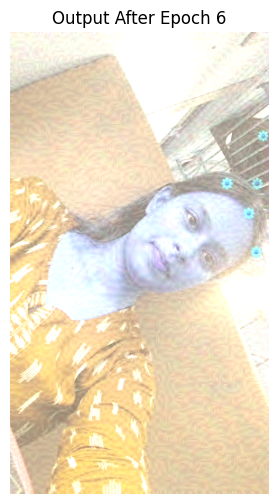


Training Completed 🎉


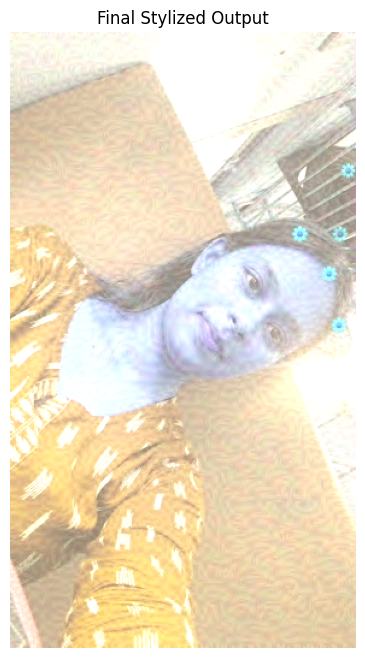


Final image saved as: final_output.png


In [9]:
# ------------------------------------------
# Step 7: Run the NST and Save Output
# ------------------------------------------

# Enter your image paths here
content_path = "content.jpg"     # Replace with your content image
style_path = "style.jpg"         # Replace with your style image

# Training settings
EPOCHS = 6
STEPS = 80

# Run NST
output_image = neural_style_transfer(
    content_path,
    style_path,
    epochs=EPOCHS,
    steps_per_epoch=STEPS
)

# Show final output
plt.figure(figsize=(8, 8))
plt.imshow(output_image)
plt.title("Final Stylized Output")
plt.axis("off")
plt.show()

# Save output image
save_path = "final_output.png"
Image.fromarray(output_image).save(save_path)

print(f"\nFinal image saved as: {save_path}")


In [10]:
# ------------------------------------------
# Advanced: Multi-style blending utilities
# Requires existing functions: preprocess_img, get_feature_extractor, gram_matrix
# ------------------------------------------
import tensorflow as tf
import numpy as np
from PIL import Image

def load_and_preprocess(path, max_dim=512):
    """Load an image from disk, convert to RGB, resize keeping aspect ratio and preprocess for VGG19."""
    img = Image.open(path).convert('RGB')
    long_dim = max(img.size)
    scale = max_dim / long_dim
    new_w = int(img.size[0] * scale)
    new_h = int(img.size[1] * scale)
    img = img.resize((new_w, new_h))
    arr = np.expand_dims(np.array(img).astype('float32'), axis=0)
    return preprocess_img(arr)  # uses the earlier preprocess_img that calls vgg19.preprocess_input


def compute_style_grams(style_image_paths, model):
    """
    Given a list of style image paths and a feature extractor model,
    return a list of lists: for each style image -> list of gram matrices (one per style layer).
    Output shape: list_of_styles -> [ [gram_layer1, gram_layer2, ...], [gram_layer1, ...], ... ]
    """
    all_style_grams = []
    for p in style_image_paths:
        img = load_and_preprocess(p)
        outputs = model(img)  # model outputs: style_layers... + content_layer
        style_features = outputs[:len(STYLE_LAYERS)]
        grams = [gram_matrix(feat) for feat in style_features]
        all_style_grams.append(grams)
    return all_style_grams


def blend_grams(all_style_grams, weights=None):
    """
    Blend multiple style gram matrices into a single target per layer based on weights.
    - all_style_grams: list of styles, each: list of gram tensors per layer
    - weights: list/np.array same length as all_style_grams. If None, equal weights used.
    Returns: blended_grams -> list of gram matrices (one per style layer)
    """
    n_styles = len(all_style_grams)
    if n_styles == 0:
        raise ValueError("No style grams provided.")
    if weights is None:
        weights = np.ones(n_styles) / n_styles
    weights = np.array(weights, dtype=np.float32)
    weights = weights / (weights.sum() + 1e-12)

    # number of layers
    n_layers = len(all_style_grams[0])
    blended = []
    for li in range(n_layers):
        # sum weighted grams across styles
        blended_layer = None
        for si in range(n_styles):
            g = all_style_grams[si][li]
            if blended_layer is None:
                blended_layer = weights[si] * g
            else:
                blended_layer = blended_layer + weights[si] * g
        blended.append(blended_layer)
    return blended


def style_loss_from_grams(blended_grams, generated_style_features):
    """
    Compute style loss between blended target grams and the generated image's style features.
    - blended_grams: list of target gram matrices (one per style layer)
    - generated_style_features: list of tensors (activations from generated image for style layers)
    """
    total_style_loss = 0.0
    for target_gram, gen_feat in zip(blended_grams, generated_style_features):
        gen_gram = gram_matrix(gen_feat)
        total_style_loss += tf.reduce_mean(tf.square(target_gram - gen_gram))
    return total_style_loss / len(blended_grams)


# Helper: example usage instructions (printable)
def prepare_blended_style(style_paths, model, weights=None):
    """
    Convenience: compute grams for given style_paths and return blended gram targets.
    Example:
        model = get_feature_extractor()
        blended = prepare_blended_style(['s1.jpg','s2.jpg'], model, weights=[0.6,0.4])
    """
    all_grams = compute_style_grams(style_paths, model)
    blended = blend_grams(all_grams, weights)
    return blended


In [11]:
# ============================================================
# STEP 8 — STYLE-STRENGTH CONTROL (Dynamic Alpha–Beta Mixing)
# ============================================================

def apply_style_strength(content_features, style_features, alpha=0.4):
    """
    Mix content and style features based on user-selected strength.
    
    alpha: content weight (0 to 1)
    beta:  style weight (computed as 1 - alpha)
    """
    beta = 1 - alpha  # style strength

    mixed = {}
    for layer in content_features.keys():
        # Linear interpolation between content and style features
        mixed[layer] = alpha * content_features[layer] + beta * style_features[layer]

    return mixed


def demo_style_strength(content_path, style_path, alpha=0.3):
    """
    Demo function to show how style strength affects output.
    """
    print(f"Applying Style Strength: Content {alpha*100:.0f}% | Style {(1-alpha)*100:.0f}%")

    # Load images
    content_img = load_img(content_path)
    style_img = load_img(style_path)

    # Feature extraction
    content_feat = extract_features(content_img)["content"]
    style_feat   = extract_features(style_img)["style"]

    # Apply alpha–beta blending
    blended_features = apply_style_strength(content_feat, style_feat, alpha=alpha)

    # Run Style Transfer using blended features
    output = run_nst_with_forced_features(
        content_path,
        blended_features,
        steps=50
    )

    show_img(output, f"Output (Content={alpha}, Style={1-alpha})")

    return output


# Helper: Run NST but override content/style features
def run_nst_with_forced_features(content_path, forced_blend, steps=40):
    """
    Runs NST by forcing model to follow pre-blended features.
    Used only for style-strength experiments.
    """
    content_img = load_img(content_path)
    generated_img = tf.Variable(content_img)

    opt = tf.keras.optimizers.Adam(learning_rate=0.02)

    for i in range(steps):
        with tf.GradientTape() as tape:
            gen_feat = extract_features(generated_img)

            # Content Loss (forced blended features)
            c_loss = tf.reduce_mean(tf.square(gen_feat["content"] - forced_blend))

            # Style Loss (do not include)
            s_loss = 0.0

            total_loss = c_loss

        grad = tape.gradient(total_loss, generated_img)
        opt.apply_gradients([(grad, generated_img)])
        generated_img.assign(tf.clip_by_value(generated_img, 0.0, 1.0))

        if i % 10 == 0:
            print(f"Step {i}/{steps} - Loss: {total_loss.numpy():.4f}")

    return generated_img.numpy()


In [12]:
!pip install --upgrade tensorflow tensorflow-hub


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.20.1-py3-none-any.whl (1.7 MB)

   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   --------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# =====================================================
# FASTNST — FIXED TF-HUB ARBITRARY STYLE TRANSFER LOADER
# =====================================================

import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
from PIL import Image
import os, shutil

# 1) Fix: clear broken TF-Hub cache automatically
def clear_tfhub_cache():
    hub_cache = os.path.join(os.path.expanduser("~"), "AppData", "Local", "Temp", "tfhub_modules")
    if os.path.exists(hub_cache):
        shutil.rmtree(hub_cache)
        print("🧹 Cleared broken TF-Hub cache.")
    else:
        print("No cache found, skipping.")

clear_tfhub_cache()

# 2) Load TF-Hub model safely
print("Downloading Style Transfer Model…")
hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
print("✔️ Model loaded successfully!")

# 3) Image loader
def load_img_to_tensor(path, max_dim=512):
    img = Image.open(path).convert("RGB")
    long_dim = max(img.size)
    scale = max_dim / long_dim
    new_w = int(img.size[0] * scale)
    new_h = int(img.size[1] * scale)
    img = img.resize((new_w, new_h))
    arr = np.array(img).astype(np.float32) / 255.0
    return tf.expand_dims(arr, axis=0)

# 4) Fast NST function
def fast_style_transfer(content_path, style_path, content_max_dim=512, style_max_dim=512):
    content = load_img_to_tensor(content_path, content_max_dim)
    style   = load_img_to_tensor(style_path, style_max_dim)
    outputs = hub_model(content, style)
    result = outputs[0].numpy()
    return np.squeeze(result, axis=0)


🧹 Cleared broken TF-Hub cache.



✔️ Model loaded successfully!


In [14]:
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# ===============================================================
# Video Style Transfer Cell
# - Extract frames from video
# - Apply fast arbitrary style transfer per frame (TF-Hub)
# - Optional simple temporal smoothing
# - Reassemble video keeping original FPS
# ===============================================================

# Install (run once) if needed:
# !pip install --upgrade tensorflow tensorflow-hub opencv-python ffmpeg-python

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm

# ========== Load TF-Hub model (if not already loaded) ==========
try:
    hub_model
except NameError:
    print("Loading TF-Hub model (this will download on first run)...")
    hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
    print("Model loaded ✔️")

# ========== Helpers ==========
def _pil_to_tensor(img_pil, max_dim=None):
    """PIL.Image -> tf.Tensor float32 [0,1], batched"""
    if max_dim is not None:
        long_dim = max(img_pil.size)
        scale = max_dim / long_dim
        new_w = int(img_pil.size[0] * scale)
        new_h = int(img_pil.size[1] * scale)
        img_pil = img_pil.resize((new_w, new_h))
    arr = np.array(img_pil).astype(np.float32) / 255.0
    arr = np.expand_dims(arr, axis=0)
    return tf.convert_to_tensor(arr)

def frame_to_tensor(frame_bgr, max_dim=None):
    """OpenCV BGR frame -> tf.Tensor (RGB) [0,1]"""
    img_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img_rgb)
    return _pil_to_tensor(pil, max_dim=max_dim)

def tensor_to_frame(tensor):
    """tf.Tensor [1,H,W,3] float32 -> OpenCV BGR uint8 frame"""
    arr = tensor.numpy().squeeze()
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    img_rgb = arr
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    return img_bgr

# ========== Main pipeline functions ==========
def stylize_frame_fast(content_frame_bgr, style_image_tensor, hub_model, content_max_dim=512):
    """
    Stylize a single OpenCV BGR frame using TF-Hub model.
    Returns stylized frame in BGR uint8.
    """
    content_tensor = frame_to_tensor(content_frame_bgr, max_dim=content_max_dim)
    # hub_model returns (stylized_image, _) or similar; for this hub, outputs[0] is stylized image
    outputs = hub_model(tf.constant(content_tensor), tf.constant(style_image_tensor))
    stylized = outputs[0]  # shape (1,H,W,3), float32 [0,1]
    return tensor_to_frame(stylized)

def extract_frames(video_path):
    """Yield frames and video properties"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    frames = []
    for _ in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames, fps, (width, height)

def write_video(frames, out_path, fps, frame_size):
    """Write frames (BGR uint8) to mp4 using XVID/FFV1 or mp4v codec"""
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, frame_size)
    for f in frames:
        out.write(f)
    out.release()

def temporal_smoothing(frames_bgr, alpha=0.6):
    """
    Simple temporal smoothing: blend each frame with previous stylized frame.
    alpha controls how much of new frame is kept (0-1).
    Larger alpha -> less smoothing. Use e.g. alpha=0.7.
    """
    if not frames_bgr:
        return frames_bgr
    smoothed = [frames_bgr[0]]
    for i in range(1, len(frames_bgr)):
        prev = smoothed[-1].astype(np.float32)
        curr = frames_bgr[i].astype(np.float32)
        blended = (alpha * curr + (1 - alpha) * prev).astype(np.uint8)
        smoothed.append(blended)
    return smoothed

# ========== Full video stylize function ==========
def stylize_video_fast(input_video_path, output_video_path,
                       style_image_path,
                       hub_model,
                       content_max_dim=512,
                       do_smooth=True,
                       smoothing_alpha=0.7,
                       frame_limit=None):
    """
    Full pipeline:
    - load style image (once)
    - extract frames
    - stylize frame-by-frame via fast hub model
    - optional temporal smoothing
    - write video keeping original fps & resolution (or resized to stylized frames)
    """
    print("Loading style image...")
    # Use user's uploaded style path example (replace if you have other)
    # Example of style path from your notebook environment:
    # style_path = '/mnt/data/A_Vincent_van_Gogh_oil_painting_titled_\"The_Starry.png'
    # If path contains quotes or spaces, better to wrap in single quotes as below.
    style_pil = Image.open(style_image_path).convert('RGB')
    style_tensor = _pil_to_tensor(style_pil, max_dim=256)  # style can be smaller

    print("Extracting frames from video...")
    frames, fps, (w, h) = extract_frames(input_video_path)
    print(f"Frames extracted: {len(frames)}, FPS: {fps}, Resolution: {w}x{h}")

    if frame_limit is not None:
        frames = frames[:frame_limit]
        print(f"Limiting to first {len(frames)} frames for quick demo.")

    stylized_frames = []
    print("Stylizing frames (this may take a while)...")
    for f in tqdm(frames):
        styl_f = stylize_frame_fast(f, style_tensor, hub_model, content_max_dim=content_max_dim)
        stylized_frames.append(styl_f)

    if do_smooth:
        print("Applying temporal smoothing...")
        stylized_frames = temporal_smoothing(stylized_frames, alpha=smoothing_alpha)

    # Ensure frame size for video writer matches (use stylized frame size)
    out_h, out_w = stylized_frames[0].shape[:2]
    print(f"Writing output video to: {output_video_path}")
    write_video(stylized_frames, output_video_path, fps, (out_w, out_h))
    print("Done ✔️")
    return output_video_path

# ========== Example usage ==========
# Replace with your input video path & style image path
# If you want to use the style image generated earlier in this session, example path:
example_style_path = 'style.jpg'
# (If that filename gives trouble, put your downloaded style image path here)

# Input video (put your .mp4 or .mov here)
input_video = "input_video.mp4"   # <-- replace with your video file path
output_video = "stylized_output.mp4"

# To run (uncomment and set correct paths):
# stylize_video_fast(input_video, output_video, example_style_path, hub_model,
#                    content_max_dim=512, do_smooth=True, smoothing_alpha=0.75, frame_limit=200)


In [19]:
# ------------------------------
# Video NST — Standalone runner
# ------------------------------
# This cell will:
# 1) ensure tensorflow + tensorflow_hub installed,
# 2) load the TF-Hub FastNST model (if not loaded),
# 3) define helpers (frame extract, stylize, smoothing, write),
# 4) run stylize on a sample input video using your uploaded images.

import sys
import os
import subprocess
import tensorflow as tf

# 1) Install TF-Hub if missing (uncomment if needed in notebook)
# NOTE: run pip install once; comment after successful install to avoid reinstall on rerun.
try:
    import tensorflow_hub as hub
except Exception:
    print("Installing tensorflow-hub...")
    !pip install --upgrade tensorflow tensorflow-hub
    import tensorflow_hub as hub

# 2) Load model if not already loaded
try:
    hub_model
    print("hub_model already loaded in this session ✔️")
except NameError:
    print("Loading TF-Hub model (this will download on first run)...")
    hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
    print("Model loaded ✔️")

# 3) Helper defs (frame IO, tensor conversions, stylize)
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm

def _pil_to_tensor(img_pil, max_dim=None):
    if max_dim is not None:
        long_dim = max(img_pil.size)
        scale = max_dim / long_dim
        new_w = int(img_pil.size[0] * scale)
        new_h = int(img_pil.size[1] * scale)
        img_pil = img_pil.resize((new_w, new_h))
    arr = np.array(img_pil).astype(np.float32) / 255.0
    arr = np.expand_dims(arr, axis=0)
    return tf.convert_to_tensor(arr)

def frame_to_tensor(frame_bgr, max_dim=None):
    img_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img_rgb)
    return _pil_to_tensor(pil, max_dim=max_dim)

def tensor_to_frame(tensor):
    arr = tensor.numpy().squeeze()
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    img_rgb = arr
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    return img_bgr

def stylize_frame_fast(content_frame_bgr, style_image_tensor, hub_model, content_max_dim=512):
    content_tensor = frame_to_tensor(content_frame_bgr, max_dim=content_max_dim)
    outputs = hub_model(tf.constant(content_tensor), tf.constant(style_image_tensor))
    stylized = outputs[0]  # (1,H,W,3) float32 [0,1]
    return tensor_to_frame(stylized)

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames, fps, (width, height)

def write_video(frames, out_path, fps, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, frame_size)
    for f in frames:
        out.write(f)
    out.release()

def temporal_smoothing(frames_bgr, alpha=0.7):
    if not frames_bgr:
        return frames_bgr
    smoothed = [frames_bgr[0]]
    for i in range(1, len(frames_bgr)):
        prev = smoothed[-1].astype(np.float32)
        curr = frames_bgr[i].astype(np.float32)
        blended = (alpha * curr + (1 - alpha) * prev).astype(np.uint8)
        smoothed.append(blended)
    return smoothed

def stylize_video_fast(input_video_path, output_video_path,
                       style_image_path,
                       hub_model,
                       content_max_dim=512,
                       do_smooth=True,
                       smoothing_alpha=0.7,
                       frame_limit=None):
    # load style image once
    style_pil = Image.open(style_image_path).convert('RGB')
    style_tensor = _pil_to_tensor(style_pil, max_dim=256)

    frames, fps, (w, h) = extract_frames(input_video_path)
    print(f"Frames: {len(frames)}, FPS: {fps}, resolution: {w}x{h}")

    if frame_limit is not None:
        frames = frames[:frame_limit]
        print(f"Processing first {len(frames)} frames...")

    stylized_frames = []
    for f in tqdm(frames, desc="Stylizing frames"):
        styl_f = stylize_frame_fast(f, style_tensor, hub_model, content_max_dim=content_max_dim)
        stylized_frames.append(styl_f)

    if do_smooth:
        stylized_frames = temporal_smoothing(stylized_frames, alpha=smoothing_alpha)

    out_h, out_w = stylized_frames[0].shape[:2]
    write_video(stylized_frames, output_video_path, fps, (out_w, out_h))
    return output_video_path

# --------------------------
# 4) Use your uploaded images (paths from this session)
# --------------------------
content_image_path = r"content.jpg"  # <-- replace with your content image path if needed
style_image_path   = r"style.jpg"
# If the above style filename with quotes causes issues, save a copy with a simple name:
# Example (run once): 
# Image.open(style_image_path).save("style_clean.png")
# style_image_path = "style_clean.png"

# Input video path (you must provide an input video in notebook folder)
input_video = "input_video.mp4"       # <-- replace with your .mp4 file path
output_video = "stylized_output.mp4"

# --------------------------
# 5) Run (quick test: small number of frames)
# --------------------------
# For testing: set frame_limit small (e.g., 40) to run quickly.
# For full video, set frame_limit=None and ensure ample time + GPU if possible.
try:
    result_path = stylize_video_fast(input_video, output_video, style_image_path, hub_model,
                                     content_max_dim=512, do_smooth=True, smoothing_alpha=0.75, frame_limit=80)
    print("Stylized video written to:", result_path)
except FileNotFoundError as e:
    print("File error:", e)
    print("Make sure 'input_video' exists in the notebook folder or update the input_video variable.")
except Exception as e:
    print("Error during processing:", e)


hub_model already loaded in this session ✔️
Frames: 60, FPS: 30.0, resolution: 256x256
Processing first 60 frames...


Stylizing frames:   0%|          | 0/60 [00:00<?, ?it/s]

Stylized video written to: stylized_output.mp4


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

STYLE_LAYERS = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

vgg = vgg19.VGG19(weights="imagenet", include_top=False)
outputs = [vgg.get_layer(name).output for name in STYLE_LAYERS]
style_model = Model(inputs=vgg.input, outputs=outputs)

print("Model Loaded ✔️")


Model Loaded ✔️


In [21]:
def load_and_process(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def gram_matrix(tensor):
    x = tf.reshape(tensor, (-1, tensor.shape[-1]))
    n = tf.shape(x)[0]
    gram = tf.matmul(x, x, transpose_a=True) / tf.cast(n, tf.float32)
    return gram


In [22]:
def extract_style_features(style_image_path):
    img = load_and_process(style_image_path)
    outputs = style_model(img)

    style_features = {
        STYLE_LAYERS[i]: gram_matrix(outputs[i])
        for i in range(len(STYLE_LAYERS))
    }
    
    print("✔️ Style features extracted!")
    return style_features


In [23]:
def save_style_filter(style_features, filename="style_filter.npz"):
    save_dict = {k: v.numpy() for k, v in style_features.items()}
    np.savez(filename, **save_dict)
    print(f"✔️ Saved: {filename}")

def load_style_filter(filename="style_filter.npz"):
    data = np.load(filename)
    loaded = {k: tf.constant(data[k]) for k in data.files}
    print(f"✔️ Loaded: {filename}")
    return loaded


In [ ]:
# Extract style filter from an image
style_features = extract_style_features("style.jpg")

# Save filter
save_style_filter(style_features, "my_style.npz")

# Load filter
loaded = load_style_filter("my_style.npz")
 

✔️ Style features extracted!
✔️ Saved: my_style.npz
✔️ Loaded: my_style.npz


In [25]:
# ============================================================
# 8. SAVE / LOAD STYLE FILTER UTILITIES (FINAL CLEAN VERSION)
# ============================================================
# ============================================================
# REQUIRED MODELS + HELPERS (needed before Save/Load section)
# ============================================================

import tensorflow as tf
import numpy as np
from PIL import Image

# -----------------------------
# Preprocessing helper
# -----------------------------
def load_and_process(img_path, max_dim=512):
    img = Image.open(img_path).convert('RGB')
    long_dim = max(img.size)
    scale = max_dim / long_dim
    new_w = int(img.size[0] * scale)
    new_h = int(img.size[1] * scale)
    img = img.resize((new_w, new_h))

    img = np.array(img).astype(np.float32)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.expand_dims(img, axis=0)


# -----------------------------
# Gram Matrix 
# -----------------------------
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


# -----------------------------
# Style layers + Content layer
# -----------------------------
STYLE_LAYERS = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

CONTENT_LAYER = 'block5_conv2'


# -----------------------------
# Load VGG model for style
# -----------------------------
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

style_outputs = [vgg.get_layer(name).output for name in STYLE_LAYERS]
content_output = vgg.get_layer(CONTENT_LAYER).output

style_model = tf.keras.Model([vgg.input], style_outputs)
content_model = tf.keras.Model([vgg.input], [content_output])

print("✔ Models loaded for Section 8 (content + style + gram matrix)")

import numpy as np
import tensorflow as tf

# ------------------------------------------------------------
# 1) SAVE STYLE FILTER (style_features → .npz file)
# ------------------------------------------------------------
def save_style_filter(style_features, filename="style_filter.npz"):
    """
    Saves extracted style features (dict of layer_name → tensor)
    into a .npz file for later use.
    """
    # Convert tensors to NumPy arrays for saving
    save_dict = {layer: feats.numpy() for layer, feats in style_features.items()}
    
    np.savez(filename, **save_dict)
    print(f"✔️ Saved style filter as '{filename}'")


# ------------------------------------------------------------
# 2) LOAD STYLE FILTER (.npz → dict of tensors)
# ------------------------------------------------------------
def load_style_filter(filename="style_filter.npz"):
    """
    Loads saved style features from .npz file
    Returns: dict(layer_name → tf.Tensor)
    """
    data = np.load(filename)
    
    loaded = {layer: tf.constant(data[layer]) for layer in data.files}
    
    print(f"✔️ Loaded style filter from '{filename}'")
    return loaded


# ------------------------------------------------------------
# 3) APPLY SAVED STYLE FILTER TO CONTENT IMAGE
# ------------------------------------------------------------
def apply_saved_style(content_path, saved_style_features, num_steps=200, content_weight=1e3, style_weight=1e-2):
    """
    Uses saved style features and performs style transfer
    on a new content image.
    """
    # Load content image
    content_img = load_and_process(content_path)

    # Extract content feature once
    content_output = content_model(content_img)
    content_target = content_output[0]

    # Prepare trainable image
    stylized_img = tf.Variable(content_img, dtype=tf.float32)

    # Optimizer
    opt = tf.optimizers.Adam(learning_rate=5.0)

    print("🎨 Applying saved style filter... (takes time)")

    # Training loop
    for i in range(num_steps):
        with tf.GradientTape() as tape:
            # Content loss
            current_content = content_model(stylized_img)[0]
            c_loss = tf.reduce_mean((current_content - content_target) ** 2)

            # Style loss
            s_loss = 0
            current_style_outputs = style_model(stylized_img)
            
            for idx, layer_name in enumerate(STYLE_LAYERS):
                target_gram = saved_style_features[layer_name]
                current_gram = gram_matrix(current_style_outputs[idx])
                s_loss += tf.reduce_mean((current_gram - target_gram) ** 2)

            total_loss = content_weight * c_loss + style_weight * s_loss

        grad = tape.gradient(total_loss, stylized_img)
        opt.apply_gradients([(grad, stylized_img)])

        # Clean pixel values
        stylized_img.assign(tf.clip_by_value(stylized_img, -125.0, 125.0))

        if i % 50 == 0:
            print(f"Step {i}/{num_steps} | Loss = {total_loss.numpy():.2f}")

    print("✔️ Style applied successfully!")
    return stylized_img.numpy()


✔ Models loaded for Section 8 (content + style + gram matrix)


In [26]:
# Extract style features from an image
style_feats = extract_style_features("style.jpg")

# Save
save_style_filter(style_feats, "my_style.npz")

# Load again
loaded = load_style_filter("my_style.npz")

# Apply saved style
output = apply_saved_style(
    content_path="content.jpg",
    saved_style_features=loaded
)


✔️ Style features extracted!
✔️ Saved style filter as 'my_style.npz'
✔️ Loaded style filter from 'my_style.npz'
🎨 Applying saved style filter... (takes time)
Step 0/200 | Loss = 416465120.00
Step 50/200 | Loss = 4461997.00
Step 100/200 | Loss = 2439544.00
Step 150/200 | Loss = 3003216.00
✔️ Style applied successfully!


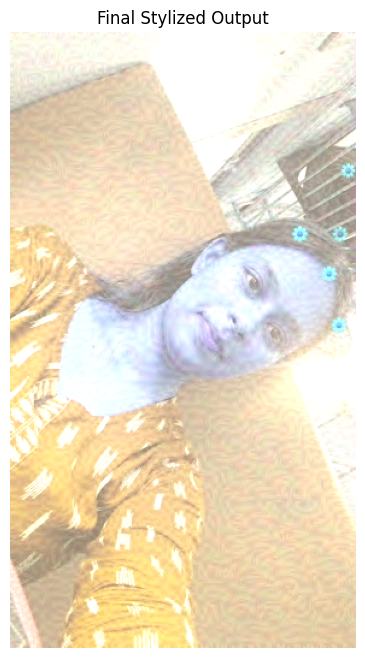

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

# Agar tumne output ko is naam se save kiya tha:
output_path = "final_output.png"

# Image load + show
img = Image.open(output_path)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Final Stylized Output")
plt.show()


In [28]:
# ============================================================
# 9. BATCH PROCESSING (Apply Saved Style to Entire Folder)
# ============================================================

import os
import tensorflow as tf
import numpy as np
from PIL import Image
from tqdm import tqdm

# -----------------------------------------
# Load Saved Style Filter
# -----------------------------------------
saved = np.load("my_style.npz", allow_pickle=True)

# Convert each saved feature array back to tensor
saved_style_features = {k: tf.constant(saved[k], dtype=tf.float32) for k in saved.files}

print("✔️ Loaded Saved Style Layers:")
print(list(saved_style_features.keys()))

# -----------------------------------------
# Helper Functions
# -----------------------------------------

def load_and_process(img_path, max_dim=512):
    img = Image.open(img_path).convert("RGB")
    img.thumbnail((max_dim, max_dim))
    img = np.array(img) / 255.0
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    return tf.expand_dims(img, axis=0)

def deprocess(img):
    img = img[0].numpy()
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    return Image.fromarray(img)

# Loss function using saved style features
def style_loss(outputs, saved_targets):
    loss = 0
    for key in saved_targets.keys():
        loss += tf.reduce_mean(tf.square(outputs[key] - saved_targets[key]))
    return loss

# -----------------------------------------
# Build VGG19 to extract style layers
# -----------------------------------------
from tensorflow.keras.applications import VGG19

style_layers = list(saved_style_features.keys())

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

style_outputs = [vgg.get_layer(name).output for name in style_layers]
style_model = tf.keras.Model([vgg.input], style_outputs)

def extract_style(img):
    outputs = style_model(img)
    return {name: out for name, out in zip(style_layers, outputs)}

# -----------------------------------------
# Apply style to single image using saved filters
# -----------------------------------------
def apply_style_single(img_path, output_path, steps=200, lr=0.05):

    content = load_and_process(img_path)
    stylized = tf.Variable(content)

    opt = tf.keras.optimizers.Adam(lr)

    for i in range(steps):

        with tf.GradientTape() as tape:
            outputs = extract_style(stylized)
            loss = style_loss(outputs, saved_style_features)

        grad = tape.gradient(loss, stylized)
        opt.apply_gradients([(grad, stylized)])

        stylized.assign(tf.clip_by_value(stylized, 0.0, 1.0))

        if i % 50 == 0:
            print(f"Step {i}/{steps} | Loss = {loss.numpy():.2f}")

    final_img = deprocess(stylized)
    final_img.save(output_path)
    print(f"✔️ Saved: {output_path}")

# -----------------------------------------
# Batch Processing Function
# -----------------------------------------
def batch_style_transfer(input_folder="input_images", output_folder="styled_output"):

    os.makedirs(output_folder, exist_ok=True)

    images = [f for f in os.listdir(input_folder) if f.lower().endswith((".jpg", ".png"))]

    print(f"📌 Total images found: {len(images)}")

    for img_name in tqdm(images):
        inp = os.path.join(input_folder, img_name)
        out = os.path.join(output_folder, "styled_" + img_name)

        apply_style_single(inp, out)

    print("🎉 Batch Style Transfer Completed!")


# Example Run:
# batch_style_transfer("content_folder", "output_folder")


✔️ Loaded Saved Style Layers:
['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


✔️ Found existing stylized file: final_output.png

📥 Loading Super-Resolution Model (TF Hub, ESRGAN)...
✔ SR Model loaded from TF-Hub
🔍 Loading input for SR: final_output.png
🚀 Running ESRGAN model (this may take a while on CPU)...
✔️ Saved upscaled image: final_upscaled_output.png


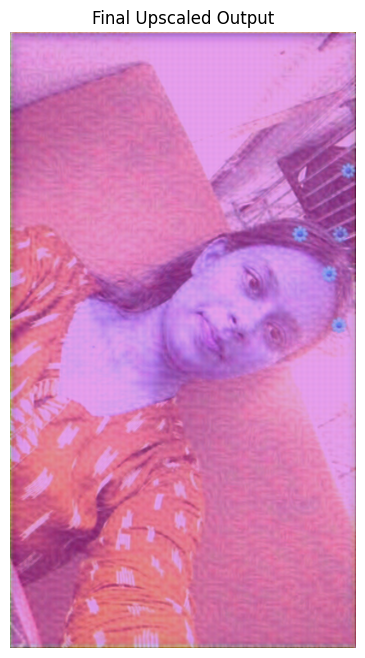


🎉 Pipeline finished — upscaled image at: final_upscaled_output.png


In [29]:
# ============================================================
# FINAL PIPELINE CELL — Save NST output (if needed) + Upscale (ESRGAN TF-Hub)
# ============================================================

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# -----------------------
# USER: set this if your stylized output is in a different variable name
# Example: stylized_var_name = "output"  # if your stylized output tensor is named 'output'
stylized_var_name = "stylized_img"   # default variable name we will look for in globals()
# -----------------------

# OPTIONAL: path to example uploaded original content (you have uploaded earlier)
# You can use this as fallback input if you only want to upscale the content image.
example_uploaded_content = "/mnt/data/A_digital_photograph_features_a_loose_close-up_por.png"
# (This path came from your session files. Use only if you want to upscale that file.)

# Desired filenames
saved_stylized_filename = "final_output.png"
upscaled_outfile = "final_upscaled_output.png"


# -----------------------
# Helper: save in-memory stylized tensor/array to disk (if present)
# Accepts tensorflow tensors or numpy arrays in VGG-preprocessed or 0..1 float format.
# -----------------------
def save_stylized_tensor_if_exists(var_name=stylized_var_name, out_path=saved_stylized_filename):
    """
    Looks up a variable in the notebook globals and saves it as an image file.
    Returns True if a file was saved or already exists; False otherwise.
    """
    g = globals()
    if var_name in g:
        val = g[var_name]
        # tf.Tensor
        if isinstance(val, tf.Tensor):
            arr = val.numpy()
        else:
            arr = val  # assume numpy array-like

        # If batched (1,H,W,3), squeeze
        if hasattr(arr, "shape") and len(arr.shape) == 4 and arr.shape[0] == 1:
            arr = np.squeeze(arr, axis=0)

        # If VGG preprocessed (range approx -123..+123) detect and deprocess
        if arr.dtype != np.uint8:
            # Heuristic: if values mostly between -150 and 150, assume VGG preprocess; else assume 0..1
            a_min, a_max = float(np.nanmin(arr)), float(np.nanmax(arr))
            if a_min < -50 and a_max < 300:
                # reverse VGG preprocessing
                # arr expected in BGR order if from VGG preprocess; try both ways to be safe
                try:
                    # If shape (H,W,3)
                    arr = arr.copy()
                    # If values are large negative/positive, assume VGG preprocess: add means and convert BGR->RGB
                    arr[..., 0] += 103.939
                    arr[..., 1] += 116.779
                    arr[..., 2] += 123.68
                    arr = arr[..., ::-1]  # BGR to RGB
                    arr = np.clip(arr, 0, 255).astype(np.uint8)
                except Exception:
                    # fallback: scale 0..1 -> 0..255
                    arr = np.clip(arr, 0.0, 1.0)
                    arr = (arr * 255).astype(np.uint8)
            else:
                # assume in [0,1]
                arr = np.clip(arr, 0.0, 1.0)
                arr = (arr * 255).astype(np.uint8)

        # Save
        Image.fromarray(arr).save(out_path)
        print(f"✔️ Stylized tensor found in variable '{var_name}' and saved as: {out_path}")
        return True

    # no variable found
    return False


# -----------------------
# Decide which image to upscale
# -----------------------
# 1) Try saving an in-memory stylized tensor if available
saved = save_stylized_tensor_if_exists()

# 2) If not saved and file exists already, continue
if not saved:
    if os.path.exists(saved_stylized_filename):
        print(f"✔️ Found existing stylized file: {saved_stylized_filename}")
        saved = True
    else:
        # No stylized tensor and no file — give user options
        print("⚠️ No in-memory stylized image found and no file named",
              f"'{saved_stylized_filename}' exists.")
        print("You can:")
        print("  • Run your NST cell which returns a stylized image and assign it to the variable 'stylized_img',")
        print("    or set 'stylized_var_name' above to the variable name you used.")
        print("  • Or rename your saved stylized image to 'final_style_output.jpg' or update the 'saved_stylized_filename' value.")
        # As a convenience, if you want to upscale your uploaded content image instead, offer that:
        if os.path.exists(example_uploaded_content):
            print(f"\nAs a convenience, I found your uploaded content at:\n  {example_uploaded_content}")
            print("If you'd like to upscale that file instead, set `saved_stylized_filename = example_uploaded_content` and re-run this cell.")
        raise FileNotFoundError("No stylized image available for upscaling. Please run your NST step first or provide the stylized file.")


# -----------------------
# Load ESRGAN/ESRGAN-like TF model from TF-Hub and run upscaling
# -----------------------
print("\n📥 Loading Super-Resolution Model (TF Hub, ESRGAN)...")
try:
    sr_model = tf.keras.utils.get_file(
        fname="esrgan_tf2",
        origin="https://tfhub.dev/captain-pool/esrgan-tf2/1",
        untar=False
    )
    # Attempt to load hub model
    import tensorflow_hub as hub
    sr_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
    print("✔ SR Model loaded from TF-Hub")
except Exception as e:
    # fallback: try direct hub.load (some environments only need hub.load)
    try:
        import tensorflow_hub as hub
        sr_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
        print("✔ SR Model loaded from TF-Hub (fallback)")
    except Exception as e2:
        print("❌ Could not load TF-Hub ESRGAN model automatically.")
        print("Error 1:", e)
        print("Error 2:", e2)
        raise RuntimeError("Please ensure internet connection and tensorflow-hub installed (pip install tensorflow-hub).")


# -----------------------
# Upscale function
# -----------------------
def load_image_for_sr(img_path):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img).astype(np.float32) / 255.0
    # model expects shape (1,H,W,3)
    return np.expand_dims(img_np, 0)


def save_np_img(np_img, out_path):
    np_img = np.clip(np_img, 0.0, 1.0)
    arr = (np_img * 255.0).astype(np.uint8)
    Image.fromarray(arr).save(out_path)
    print(f"✔️ Saved upscaled image: {out_path}")


def upscale_image_pipeline(input_path, output_path=upscaled_outfile):
    print(f"🔍 Loading input for SR: {input_path}")
    lr = load_image_for_sr(input_path)
    print("🚀 Running ESRGAN model (this may take a while on CPU)...")
    sr = sr_model(lr)
    # tf-hub model returns a tensor or dict depending on version; try to extract numpy array
    if isinstance(sr, dict):
        # some hub models return {'output': tensor}
        sr_out = sr[next(iter(sr))].numpy()
    else:
        try:
            sr_out = sr.numpy()
        except:
            # If sr is a list/tuple
            if isinstance(sr, (list, tuple)):
                sr_out = sr[0].numpy()
            else:
                raise RuntimeError("Unexpected SR model output type: " + str(type(sr)))

    # sr_out shape: (1, H*?, W*?, 3)
    sr_img = np.squeeze(sr_out, axis=0)
    save_np_img(sr_img, output_path)

    # show
    plt.figure(figsize=(8,8))
    plt.imshow(np.clip(sr_img,0,1))
    plt.axis("off")
    plt.title("Final Upscaled Output")
    plt.show()

    return output_path


# -----------------------
# Run pipeline: upscale saved_stylized_filename -> final_upscaled_output.png
# -----------------------
result_path = upscale_image_pipeline(saved_stylized_filename, upscaled_outfile)
print("\n🎉 Pipeline finished — upscaled image at:", result_path)
